# Example 2 — Pipe network with geometry-based lengths

This example corresponds to **Example 4.20** from:

* Brebbia, C. A., & Ferrante, A. J. (2013). *Computational Hydraulics*. Butterworth-Heinemann.

<img src = "images/example4_20.svg" width = "500">

The problem is similar to **Example 1**, but introduces an important conceptual extension:

> **Pipe lengths are not prescribed directly**.
> Instead, they are **computed from nodal coordinates**, using the network geometry.

⚠️ **Note on the reference**
In the book, there are small inconsistencies between:

* the numerical values listed in the problem statement, and
* the values effectively used in the code that produces the reported results.

This implementation follows the **geometry-based interpretation**, which is consistent with the reported solution.

---

## 1. Physical description of the problem

The network consists of:

* **5 nodes**
* **6 pipes**

Known boundary conditions:

* Prescribed hydraulic head:

  * $H_1 = 100\ \mathrm{m}$
* Prescribed nodal demands:

  * $c_2 = -0.2\ \mathrm{m^3,s^{-1}}$
  * $c_3 = -0.5\ \mathrm{m^3,s^{-1}}$
  * $c_4 = -0.25\ \mathrm{m^3,s^{-1}}$

Negative values indicate **outflows (demands)**.

Each pipe is defined by its **diameter**, while its **length is computed from node coordinates**.

---

## 2. Governing equations

As in Example 1, the system is modeled as a **linear diffusive network**.

For each pipe (element) $i$ connecting nodes $k$ and $j$:

$$
\begin{bmatrix}
Q_k^i \\
Q_j^i
\end{bmatrix}
= k^i
\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}
\begin{bmatrix}
H_k \\
H_j
\end{bmatrix}
$$

The hydraulic conductance is:

$$
k^i = \frac{\pi , c , D_i^4}{128 , L_i}
$$

where:

* $D_i$ is the pipe diameter,
* $L_i$ is the pipe length (computed geometrically),
* $c$ is a constant lumping fluid and gravity effects.

---

## 3. Step 1 — Create the network and connectivity

In [1]:
import numpy as np
import netsystems as ns

In [2]:
net = ns.Network()

connectivity = np.array([
    [0, 1],
    [1, 3],
    [1, 4],
    [1, 2],
    [3, 4],
    [2, 4]
])

net.set_connectivity(connectivity)

Each row defines one pipe connecting two nodes.

## 4. Step 2 — Define node coordinates

Here lies the **key difference with Example 1**.

Instead of specifying pipe lengths directly, we provide **node coordinates**:

In [3]:
net.node_coordinates = np.array([
    [0, 0],
    [500, 500],
    [1100, 500],
    [500.01, 200],
    [1100.01, 200]
])

Each row corresponds to one node:

* first column → $x$ coordinate,
* second column → $y$ coordinate.

## 5. Step 3 — Compute pipe lengths from geometry

The length of each element is computed as the Euclidean distance:

$$
L_i = \sqrt{(x_j - x_k)^2 + (y_j - y_k)^2}
$$

This is done automatically by:

In [4]:
net.calculate_element_lengths()

The resulting values are stored in:

In [5]:
net.element_lengths

array([707.10678119, 300.00000017, 670.82933754, 600.        ,
       600.        , 300.00000017])

## 6. Step 4 — Define the diffusive system

In [6]:
fluid = ns.System("fluid", system_type="diffusive")

fluid.x_name = "H"
fluid.b_name = "C"
fluid.element_variable_name = "Q"

This establishes:

* unknown $x \equiv H$ (hydraulic head),
* nodal source term $b \equiv c$,
* edge variable $\equiv Q$ (pipe flow rate).

---

## 7. Step 5 — Apply boundary conditions

### Prescribed head

In [7]:
fluid.known_x_nodes = np.array([0])
fluid.known_x_values = np.array([100.])

This enforces:

* $H_0 = 100\ \mathrm{m}$.

### Prescribed nodal demands

In [8]:
fluid.known_b_nodes = np.array([2, 4, 3])
fluid.known_b_values = np.array([-0.2, -0.25, -0.5])

Negative values represent **outflow from the network**.

---

## 8. Step 6 — Define pipe diameters and conductance

In [9]:
diam = np.array([0.15, 0.1, 0.075, 0.1, 0.15, 0.15])
g = 9.81
cte = 10000000.

The hydraulic conductance is computed as:

$$
k^i = \frac{\pi , c , D_i^4}{128 , L_i}
$$

which corresponds directly to:

In [10]:
fluid.element_conductance = (
    np.pi * cte * diam[:]**4 / (128. * net.element_lengths)
)

This vector assigns one conductance value per pipe.

---

## 9. Step 7 — Register the system and solve

In [11]:
net.add_system(fluid)

ns.solve_linear_system(net, "fluid")

0

Internally, this performs:

1. global matrix assembly,
2. partitioning into known and unknown nodes,
3. solution of the reduced linear system,
4. reconstruction of full nodal heads,
5. computation of pipe flow rates.

---

## 10. Step 8 — Visualize the network geometry

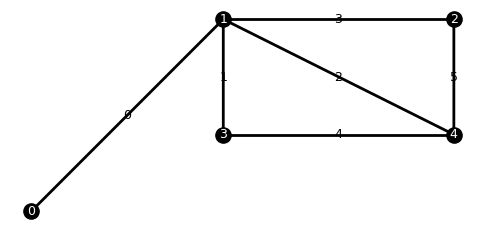

In [12]:
ns.plot_network_geometry(
    net,
    show_nodes=True,
    show_elements=True,
    show_node_numbers=True,
    show_element_numbers=True,
    node_size=120,
    node_color="black",
    line_color="black",
    line_width=2.0,
    figure_size=(6, 6),
    title=None,
    axis_off=True,
    save_figure=False,
)

## 11. Step 9 — Visualize hydraulic results

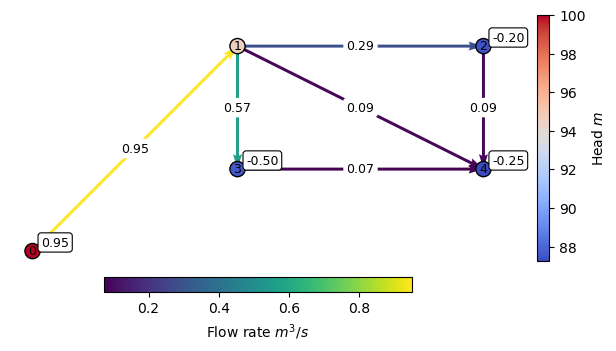

In [14]:
ns.plot_network_results(
    net,
    "Q",
    "C",
    node_values=net.get("H"),
    element_values=net.get("Q"),
    node_cmap="coolwarm",
    element_cmap="viridis",

    show_node_numbers=True,
    show_element_numbers=True,
    show_flow_arrows=True,

    show_element_values=True,
    element_value_format="{:.2f}",
    element_value_fontsize=9,
    element_value_color="black",
    element_value_bbox=True,

    show_node_demands=True,
    node_demand_format="{:.2f}",
    node_demand_fontsize=9,
    node_demand_color="black",
    node_demand_offset=(21, 21),
    node_demand_bbox=True,

    node_size=120,
    line_width=3.0,
    arrow_scale=1.0,
    arrow_width=0.006,
    figure_size=(8, 4),

    node_colorbar_label="Head $m$",
    element_colorbar_label="Flow rate $m^3/s$",
    title=None,
    axis_off=True,
    save_figure=False,
)

This visualization simultaneously shows:

* nodal heads,
* pipe flow rates,
* flow direction,
* imposed nodal demands.